In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
REBUILD_DATA = True #set to true to once, then back to false unless you want to change something in your training data

class CovidvsNormal():
    IMG_SIZE = 224
    NORMAL = "data/NORMAL"
    COVID = "data/COVID-19"
    LABELS = {NORMAL:0, COVID:1}
    
    training_data = []
    normalcount = 0
    covidcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "png" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.NORMAL:
                            self.normalcount += 1
                        elif label == self.COVID:
                            self.covidcount += 1
                    except Exception as e:
                        pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("NORMAL:", self.normalcount)
        print("COVID:", self.covidcount)



model = models.vgg16(pretrained=True)
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(5000, 2)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")    


if REBUILD_DATA:
    covidvnormal = CovidvsNormal()
    covidvnormal.make_training_data()

training_data = np.load("training_data.npy")
print(len(training_data))

ModuleNotFoundError: No module named 'cv2'

156
1404
156


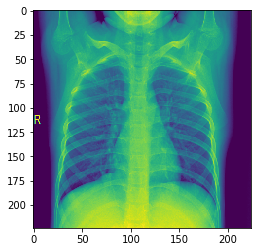

In [13]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 224, 224)
X = X/255.0 
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))
import matplotlib.pyplot as plt

plt.imshow(X[0].view(224, 224))
plt.show()

In [18]:
BATCH_SIZE = 8
EPOCHS = 10
def train():
        epochs = 15
        steps = 0
        print_every = 40

        model.to('cuda')

        for e in range(epochs):
        
            model.train()
    
            running_loss = 0
    
            for images, labels in iter(train_loader):
        
                steps += 1
        
                images, labels = images.to('cuda'), labels.to('cuda')
        
                optimizer.zero_grad()
        
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
        
                running_loss += loss.item()
        
                if steps % print_every == 0:
                
                    model.eval()
                
                    # Turn off gradients for validation, saves memory and computations
                    with torch.no_grad():
                        validation_loss, accuracy = validation(model, validate_loader, criterion)
            
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))
            
                    running_loss = 0
                    model.train()
              
train()

  0%|                                                                                         | 0/176 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size 64 3 3 3, expected input[8, 1, 224, 224] to have 3 channels, but got 1 channels instead